In [115]:
import os
import sys
import h5py
import json
import numpy as np
import torch as pt
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from sklearn import metrics

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 14

from theme import colors

from src.dataset import StructuresDataset, collate_batch_features, select_by_sid, select_by_max_ba, select_by_interface_types
from src.data_encoding import encode_structure, encode_features, extract_topology, categ_to_resnames, resname_to_categ, extract_all_contacts
from src.structure import data_to_structure, encode_bfactor, concatenate_chains
from src.structure_io import save_pdb, read_pdb
from src.scoring import bc_scoring, bc_score_names, nanmean

In [116]:
save_path = "model/save/i_v4_1_2021-09-07_11-21"  # 91
model_filepath = os.path.join(save_path, 'model_ckpt.pt')

# add module to path
if save_path not in sys.path:
    sys.path.insert(0, save_path)
    
# load functions
from config import config_model, config_data
from data_handler import Dataset
from model import Model

# define device
device = pt.device("cpu")

# create model
model = Model(config_model)

# reload model
model.load_state_dict(pt.load(model_filepath, map_location=pt.device("cpu")))

# set model to inference
model = model.eval().to(device)

In [129]:
def setup_dataset(config_data, r_types_sel):
    # set up dataset
    dataset = Dataset("data/datasets/contacts_rr5A_64nn_8192_wat3.h5")
    # selected structures
    sids_sel = np.genfromtxt("data/datasets/subunits_test18.txt", dtype=np.dtype('U'))

    # filter dataset
    m = select_by_sid(dataset, sids_sel) # select by sids
    
    # data selection criteria
    m &= select_by_max_ba(dataset, config_data['max_ba'])  # select by max assembly count

    m &= select_by_interface_types(dataset, categ_to_resnames['rna'], np.concatenate(r_types_sel))  # select by interface type

    # update dataset selection
    dataset.update_mask(m)

    # set dataset types
    dataset.set_types(categ_to_resnames['rna'], config_data['r_types'])

    # debug print
    return dataset


def eval_model(model, dataset, ids):
    p_l, y_l = [], []
    with pt.no_grad():
        for i in tqdm(ids):
            # get data
            X, ids_topk, q, M, y = dataset[i]

            # pack data and setup sink (IMPORTANT)
            X, ids_topk, q, M = collate_batch_features([[X, ids_topk, q, M]])

            # run model
            z = model(X.to(device), ids_topk.to(device), q.to(device), M.float().to(device))

            # prediction
            p = pt.sigmoid(z)

            # categorical predictions
            pc = pt.cat([1.0 - pt.max(p, axis=1)[0].unsqueeze(1), p], axis=1).cpu()
            yc = pt.cat([1.0 - pt.any(y > 0.5, axis=1).float().unsqueeze(1), y], axis=1).cpu()
            
            print("PC shape - ", pc.shape)
            print("YC shape - ", yc.shape)
            # tot_count = 0
            # int_count = 0
            # for k in pc:
            #     if k[2] >0.5:
            #         int_count+=1
            #     tot_count +=1

            # print("Interfaces ", int_count, tot_count, int_count/tot_count)


            # data
            p_l.append(pc)
            y_l.append(yc)
            
    return p_l, y_l

In [131]:
p_l, y_l = [], []
for i in range(len(config_data['r_types'])):
    # debug print

    if i==0 or i==1 or i==2 or i==4:
        continue
    
    print(config_data['r_types'][i])

    # load datasets
    dataset = setup_dataset(config_data, [config_data['r_types'][i]])
    print("dataset: {}".format(len(dataset)))

    # parameters
    N = min(len(dataset), 512)

    # run negative examples
    ids = np.arange(len(dataset))
    np.random.shuffle(ids)
    pi_l, yi_l = eval_model(model, dataset, ids[:N])
    
    # store evaluation results
    p_l.append(pi_l)
    y_l.append(yi_l)


['SO4', 'NAG', 'PO4', 'EDO', 'ACT', 'MAN', 'HEM', 'FMT', 'BMA', 'ADP', 'FAD', 'NAD', 'NO3', 'GLC', 'ATP', 'NAP', 'BGC', 'GDP', 'FUC', 'FES', 'FMN', 'GAL', 'GTP', 'PLP', 'MLI', 'ANP', 'H4B', 'AMP', 'NDP', 'SAH', 'OXY', 'MGR', 'B12', 'SR', 'ROS', '5BU', 'NME', 'BDR', 'NEB', 'BDG', 'IDG', 'G0B', '2TB', 'TOC', 'TOA', 'LHA', 'IU', '747', 'GTP', '4BW', 'SIS']
dataset: 0


0it [00:00, ?it/s]


### Seaching interface

In [127]:
# parameters
class_names = [ "ligand" ]

# compute scores per class
scores = []
for i in range(len(y_l)):
    # extract class
    p = pt.cat(p_l[i], axis=0)[:,4]
    y = pt.cat(y_l[i], axis=0)[:,4]

    # compute scores
    s = bc_scoring(y.unsqueeze(1), p.unsqueeze(1)).squeeze().numpy()
    
    # compute F1 score
    f1 = metrics.f1_score(y.numpy().astype(int), p.numpy().round())
    
    # compute ratio of positives
    r = pt.mean(y)
    
    # store results
    scores.append(np.concatenate([s, [f1, r]]))
    
# pack data
scores = np.stack(scores).T

# make table
df = pd.DataFrame(data=np.round(scores,2), index=bc_score_names+['F1', 'r'], columns=class_names)

# save dataframe
df.to_csv("type_interface_search_scores.csv")

# display
display(df)

q, y -  tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]) tensor([[0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.]])


,ligand
acc,0.20
ppv,1.00
npv,0.16
tpr,0.06
tnr,1.00
mcc,0.10
auc,0.71
std,0.10
F1,0.11
r,0.85


In [100]:
from model import unpack_state_features
def eval_model(model, dataset, ids):
    p_l, y_l = [], []
    with pt.no_grad():
        for i in tqdm(ids):
            # get data
            X, ids_topk, q, M, y = dataset[i]

            # Get structure code (For residue wise prediction)
            str1 = 'Test18PDB1/1qdn.pdb1'
            pdb_filepaths = [str1]
            datasetx = StructuresDataset(pdb_filepaths, with_preprocessing=True)

            # pack data and setup sink (IMPORTANT)
            X, ids_topk, q, M = collate_batch_features([[X, ids_topk, q, M]])

            q1 = model.em.forward(q)
            p0 = pt.zeros((q1.shape[0]+1, X.shape[1], q1.shape[1]), device=X.device)
            q1, ids_topk, D_nn, R_nn = unpack_state_features(X, ids_topk, q1)
            qa, pa, _, _, _ = model.sum.forward((q1, p0, ids_topk, D_nn, R_nn))
            zr = pt.cat([qa[1:], pt.norm(pa[1:], dim=1)], dim=1)
            z = model.dm.forward(zr)
            p = pt.sigmoid(z)

            # categorical predictions
            pc = pt.cat([1.0 - pt.max(p, axis=1)[0].unsqueeze(1), p], axis=1).cpu()
            yc = pt.cat([1.0 - pt.any(y > 0.5, axis=1).float().unsqueeze(1), y], axis=1).cpu()
            
            #New predictions on residue level
            p_new = pt.zeros_like(yc)
            
            #Getting the predictions according to our rules
            for subunits, filepath in tqdm(datasetx):
                structure = concatenate_chains(subunits)

            atom_count = 0
            res_count = 0
            for k in range(1, len(structure['het_flag'])):
                atom_count+=1
                if structure['het_flag'][k]!='A':
                    break
                if pc[k][4]>0.5:
                    p_new[res_count][4] = pc[k][4]

                if structure['resid'][k]!=structure['resid'][k-1]:
                    res_count+=1
            res_count+=1
            # data
            p_l.append(p_new)
            y_l.append(yc)
                
    return p_l, y_l

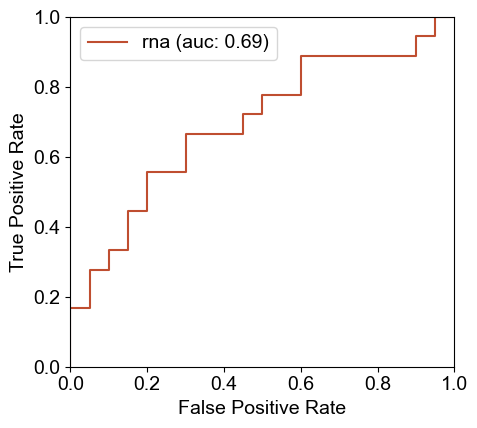

In [32]:
# parameters
class_names = ["rna", "ligand"]

# plot
plt.figure(figsize=(5,4.5))
for i in range(len(y_l)):
    # get labels and predictions for class
    yi = pt.cat(y_l[i], axis=0)[:,4]
    pi = pt.cat(p_l[i], axis=0)[:,4]

    # compute roc and roc auc
    fpr, tpr, _ = metrics.roc_curve(yi.numpy(), pi.numpy())
    auc = metrics.auc(fpr, tpr)
    
    # update plot
    plt.plot(fpr, tpr, '-', color=colors[i], label="{} (auc: {:.2f})".format(class_names[i], auc))
    
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()
# plt.savefig("results/type_interface_search_roc_auc.svg")
# plt.savefig("results/type_interface_search_roc_auc.png", dpi=300)
plt.show()

/Users/riddhishthakare/Downloads/PeSTo/penv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


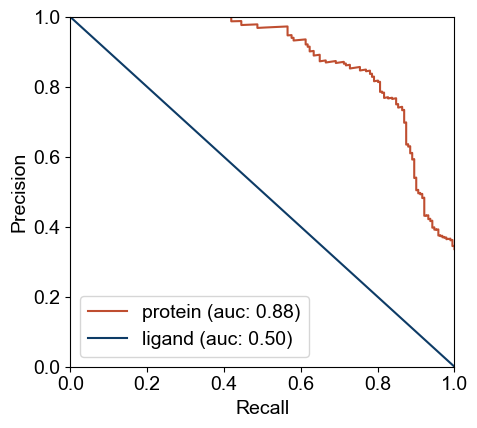

In [25]:
# parameters
class_names = ["protein","ligand"]

# plot
plt.figure(figsize=(5,4.5))
for i in range(len(y_l)):
    # get labels and predictions for class
    yi = pt.cat(y_l[i], axis=0)[:,i+1]
    pi = pt.cat(p_l[i], axis=0)[:,i+1]

    # compute roc and roc auc
    pre, rec, _ = metrics.precision_recall_curve(yi.numpy(), pi.numpy())
    auc = metrics.auc(rec, pre)
    
    # update plot
    plt.plot(rec, pre, '-', color=colors[i], label="{} (auc: {:.2f})".format(class_names[i], auc))
    
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.legend(loc='best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()
# plt.savefig("results/type_interface_search_pr_auc.svg")
# plt.savefig("results/type_interface_search_pr_auc.png", dpi=300)
plt.show()

### Interface identification

In [25]:
# parameters
class_names = ["DNA/RNA", "ligand"]

# pack results
P = pt.cat([pt.cat(p, axis=0) for p in p_l], axis=0)
Y = pt.cat([pt.cat(y, axis=0) for y in y_l], axis=0)

# select only residues at interface
m = pt.any(Y[:,1:] > 0.5, axis=1)
Pi = P[m,1:]
Yi = Y[m,1:]

# pick same sampling of all classes
n = 2
N = int(pt.min(pt.sum(Yi, axis=0)).item())
ids_unif = pt.from_numpy(np.concatenate([np.random.choice(pt.where(Yi[:,i] > 0.5)[0].numpy(), N, replace=False) for i in range(n)]))

# compute scores for each class
scores = []
for i in range(n):
    # extract class
    p = Pi[ids_unif,i]
    y = Yi[ids_unif,i]

    # compute scores
    s = bc_scoring(y.unsqueeze(1), p.unsqueeze(1)).squeeze().numpy()
    
    # compute F1 score
    f1 = metrics.f1_score(y.numpy().astype(int), p.numpy().round())
    
    scores.append(np.concatenate([s, [f1]]))
    
# pack data
scores = np.stack(scores).T

# make table
df = pd.DataFrame(data=np.round(scores,2), index=bc_score_names+['F1'], columns=class_names)

# save dataframe
# df.to_csv("results/type_interface_identification_scores.csv")

# display
display(df)

/Users/riddhishthakare/Downloads/PeSTo/penv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/riddhishthakare/Downloads/PeSTo/penv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


,DNA/RNA,ligand
acc,NaN,NaN
ppv,NaN,NaN
npv,NaN,NaN
tpr,NaN,NaN
tnr,NaN,NaN
mcc,NaN,NaN
auc,NaN,NaN
std,NaN,NaN
F1,0.0,0.0


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (2).

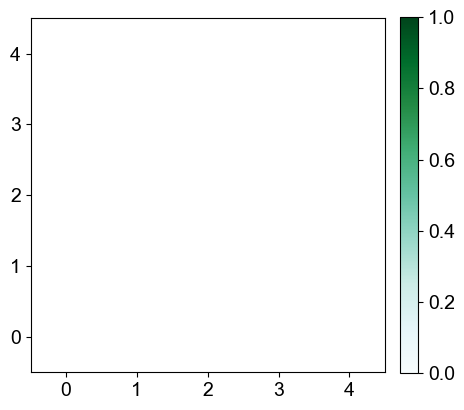

In [26]:
# pack results
P = pt.cat([pt.cat(p, axis=0) for p in p_l], axis=0)
Y = pt.cat([pt.cat(y, axis=0) for y in y_l], axis=0)

# select only residues at interface
m = pt.any(Y[:,1:] > 0.5, axis=1)
Pi = P[m,1:]
Yi = Y[m,1:]

# pick same sampling of all classes
n = Yi.shape[1]
N = int(pt.min(pt.sum(Yi, axis=0)).item())
ids_l = [pt.from_numpy(np.random.choice(pt.where(Yi[:,i] > 0.5)[0].numpy(), N, replace=False)) for i in range(n)]

# compute scores for each class
C = pt.zeros((n,n))
for i in range(n):
    ids = pt.argmax(Pi[ids_l[i]], axis=1)
    for j,k in zip(ids, ids_l[i]):
        C[i,j] += Pi[k,j].round()
        

# normalize score
H = (C / pt.sum(C, axis=1).unsqueeze(1)).numpy()
#H = (C / pt.sum(C, axis=0).unsqueeze(0)).numpy()

# plot
plt.figure(figsize=(5, 5))
plt.imshow(H, origin='lower', cmap='BuGn', vmin=0.0, vmax=1.0)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks(np.arange(n), class_names, rotation=90)
plt.yticks(np.arange(n), class_names)
for i in range(n):
    for j in range(n):
        v = H[i,j]
        if v > 0.1:
            plt.text(j,i,f"{v:.2f}", ha='center', va='center', color=[np.round(v-0.1)]*3)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.tight_layout()
plt.savefig("results/type_interface_identification_most_confident_confusion_matrix.svg")
plt.savefig("results/type_interface_identification_most_confident_confusion_matrix.png", dpi=300)
plt.show()

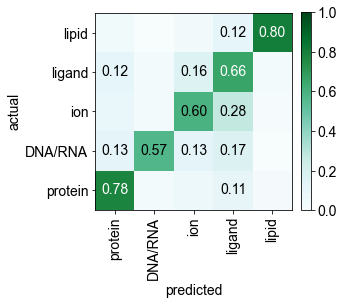

In [13]:
# pack results
P = pt.cat([pt.cat(p, axis=0) for p in p_l], axis=0)
Y = pt.cat([pt.cat(y, axis=0) for y in y_l], axis=0)

# select only residues at interface
m = pt.any(Y[:,1:] > 0.5, axis=1)
Pi = P[m,1:]
Yi = Y[m,1:]

# pick same sampling of all classes
n = Yi.shape[1]
N = int(pt.min(pt.sum(Yi, axis=0)).item())
ids_l = [pt.from_numpy(np.random.choice(pt.where(Yi[:,i] > 0.5)[0].numpy(), N, replace=False)) for i in range(n)]

# compute scores for each class
C = pt.zeros((n,n))
for i in range(n):
    ids = pt.argmax(Pi[ids_l[i]], axis=1)
    for j in range(n):
        for k in ids_l[i]:
            C[i,j] += Pi[k,j].round()
        

# normalize score
H = (C / pt.sum(C, axis=1).unsqueeze(1)).numpy()
#H = (C / pt.sum(C, axis=0).unsqueeze(0)).numpy()

# plot
plt.figure(figsize=(5, 5))
plt.imshow(H, origin='lower', cmap='BuGn', vmin=0.0, vmax=1.0)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks(np.arange(n), class_names, rotation=90)
plt.yticks(np.arange(n), class_names)
for i in range(n):
    for j in range(n):
        v = H[i,j]
        if v > 0.1:
            plt.text(j,i,f"{v:.2f}", ha='center', va='center', color=[np.round(v-0.1)]*3)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.tight_layout()
#plt.savefig("results/type_interface_identification_most_confident_confusion_matrix.svg")
#plt.savefig("results/type_interface_identification_most_confident_confusion_matrix.png", dpi=300)
plt.show()

In [61]:
import numpy as np
import torch as pt
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score


bc_score_names = ['acc','ppv','npv','tpr','tnr','mcc','auc','std']


@pt.jit.script
def binary_classification(y, q):
    # total positive and negatives
    TP = pt.sum(q * y, dim=0)
    TN = pt.sum((1.0-q) * (1.0-y), dim=0)
    FP = pt.sum(q * (1.0-y), dim=0)
    FN = pt.sum((1.0-q) * y, dim=0)
    P = pt.sum(y, dim=0)
    N = pt.sum(1.0-y, dim=0)

    return TP, TN, FP, FN, P, N


@pt.jit.script
def acc(TP, TN, FP, FN):
    return (TP + TN) / (TP + TN + FP + FN)


@pt.jit.script
def ppv(TP, FP, P):
    v = TP / (TP + FP)
    v[~(P>0)] = np.nan  # no positives -> undefined
    return v


@pt.jit.script
def npv(TN, FN, N):
    v = TN / (TN + FN)
    v[~(N>0)] = np.nan  # no negatives -> undefined
    return v


@pt.jit.script
def tpr(TP, FN):
    v = TP / (TP + FN)
    v[pt.isinf(v)] = np.nan
    return v


@pt.jit.script
def tnr(TN, FP):
    v = TN / (TN + FP)
    v[pt.isinf(v)] = np.nan
    return v

@pt.jit.script
def mcc(TP, TN, FP, FN):
    v = ((TP*TN) - (FP*FN)) / pt.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    v[pt.isinf(v)] = np.nan
    return v


def roc_auc(y, p, P, N):
    m = (P > 0) & (N > 0)
    v = pt.zeros(y.shape[1], dtype=pt.float32, device=y.device)
    if pt.any(m):
        a = np.array(roc_auc_score(y[:,m].cpu().numpy(), p[:,m].cpu().numpy(), average=None))
        v[m] = pt.from_numpy(a).float().to(y.device)
    v[~m] = np.nan
    return v


@pt.jit.script
def nanmean(x):
    return pt.nansum(x, dim=0) / pt.sum(~pt.isnan(x), dim=0)


def bc_scoring(y, p):
    # prediction
    q = pt.round(p)
    # print('q, y - ', q, y)
    # binary classification
    TP, TN, FP, FN, P, N = binary_classification(y, q)

    # compute and pack scores
    scores = pt.stack([
        acc(TP, TN, FP, FN),
        ppv(TP, FP, P),
        npv(TN, FN, N),
        tpr(TP, FN),
        tnr(TN, FP),
        mcc(TP, TN, FP, FN),
        roc_auc(y, p, P, N),
        pt.std(p, dim=0),
    ])

    return scores  # ['acc','ppv','npv','tpr','tnr','mcc','auc','std']


def reg_scoring(y, p):
    return {
        'mse': float(pt.mean(pt.square(y - p)).cpu().numpy()),
        'mae': float(pt.mean(pt.abs(y - p)).cpu().numpy()),
        'rmse': float(pt.sqrt(pt.mean(pt.square(y - p))).cpu().numpy()),
        'pcc': pearsonr(y.cpu().numpy(), p.cpu().numpy())[0] if not pt.allclose(y,y[0]) else np.nan,
        'std': float(pt.std(p).cpu().numpy()),
    }
